<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Yalda Shabanazadeh
### Student Number : 98101822
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
import os
from IPython import display
from google.colab import drive

#@markdown Run If you would like to store data in your personal drive.
#@markdown
#@markdown If you run this cell, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown Otherwise, any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
path = 'Machine Learning/HW3/Q3. NN with PyTorch' #@param

drive.mount('/gdrive')
root = f'/gdrive/My Drive/{path}'
if not os.path.isdir(root):
    os.mkdir(root)
os.chdir(root)
print(f'\nChanged CWD to "{root}"')

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Machine Learning/HW3/Q3. NN with PyTorch"


In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=19dbb2a0bd4427ff2940d0d7ea0f6f70cefab51e2ca7dbb945afeda3e81c3b6b
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import seaborn as sn
from PIL import Image
from torchviz import make_dot
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, f1_score
from typing import List

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [ ]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


In [ ]:
df.describe()

,class_label
count,4458.000000
mean,1.820996
std,0.647245
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         4458 non-null   object
 1   class_name   4458 non-null   object
 2   class_label  4458 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 104.6+ KB


In [ ]:
def plot_imgs(imgs, nrows, ncols, titles=None, **imshow_kwargs):
    assert len(imgs) <= nrows * ncols

    _, axs = plt.subplots(
        nrows=nrows, ncols=ncols, squeeze=False,
        figsize=(ncols * 4, nrows * 4)
    )
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            idx = row_idx * ncols + col_idx
            ax = axs[row_idx, col_idx]
            if titles and len(titles) > idx:
                ax.set(title=titles[idx])
                ax.title.set_size(12)
            ax.imshow(np.asarray(imgs[idx]), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def get_samples_indices(df, class_column, n=4):
    indices = list()
    classes = df[class_column].unique()
    for cls in classes:
        filtered = df[df[class_column] == cls]
        indices.extend(np.asarray(filtered.sample(n=n).index))
    return indices


def load_pimg(data_path, name):
    return Image.open(f'{os.path.join(data_path, name)}.png')

>  Visualize 4 sample from each class

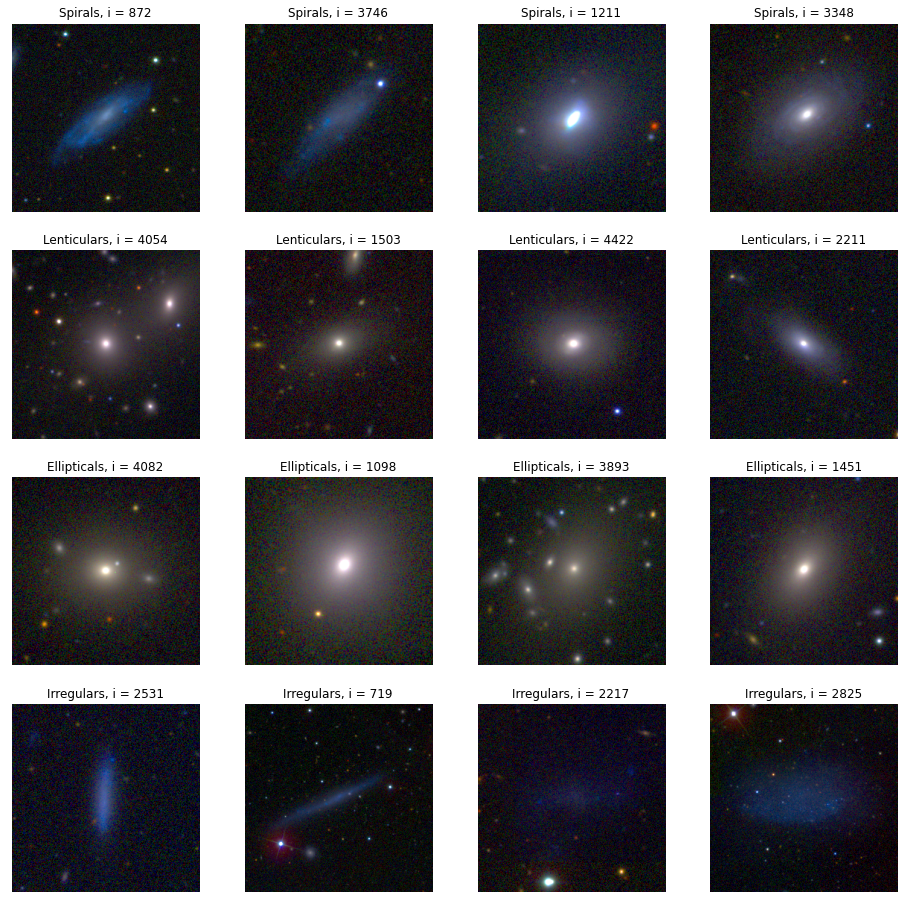

In [ ]:
data_path = './efigi-1.6/png'
indices = get_samples_indices(df, 'class_name', n=4)
titles = [f"{df.iloc[i]['class_name']}, i = {i}" for i in indices]
imgs = [load_pimg(data_path, df.iloc[i]['name']) for i in indices]

plot_imgs(imgs, 4, 4, titles)

# Define Dataset (20 Points)

> Write your dataset class for loading images

In [ ]:
class GalaxyDataSet(Dataset):
    def __init__(
        self,
        root_dir: str,
        df: pd.DataFrame = None,
        attr_path: str = None,
        download: bool = False,
        transform=None
    ):
        if download and df is None:
            download_data()
        self.df = prepare_data(attr_path) if df is None else df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = load_pimg(self.root_dir, item['name'])
        target = item['class_label']

        if self.transform:
            img = self.transform(img)
        return img, target

# Define Model (20 Points)

> Define your model

In [ ]:
class ClassifierModel(nn.Module):
    def __init__(
        self, 
        in_features: int,
        hidden_features: List = list(),
        out_features: int = 4,
    ):
        super().__init__()
        self.mlp =  nn.Sequential(nn.Flatten())
        for h in hidden_features:
            self.mlp.append(nn.Linear(in_features, h))
            self.mlp.append(nn.Tanh())
            in_features = h
        self.mlp.append(nn.Linear(h, out_features))
        self.mlp.append(nn.Softmax(dim=1))

    def forward(self, x):
        x = self.mlp(x)
        return x

# Train Model (30 Points)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [ ]:
hidden_features = [1024, 512, 128, 16]
in_features = 255 * 255
out_features = 4
net = ClassifierModel(
    in_features=in_features,
    out_features=out_features,
    hidden_features=hidden_features
)

In [ ]:
batch_size = 128

# split train and test data
dataset = GalaxyDataSet(root_dir=data_path, df=df, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# use sampler for unbalanced dataset
train_labels = list(dataset.df.values[trainset.indices, 2])
train_bincount = torch.bincount(torch.tensor(train_labels))
train_weights = np.array([1 / train_bincount[label] for label in train_labels])

samples_weight = torch.from_numpy(train_weights)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(train_weights, len(train_weights))

# build dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, num_workers=2, sampler=sampler
)
validloader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

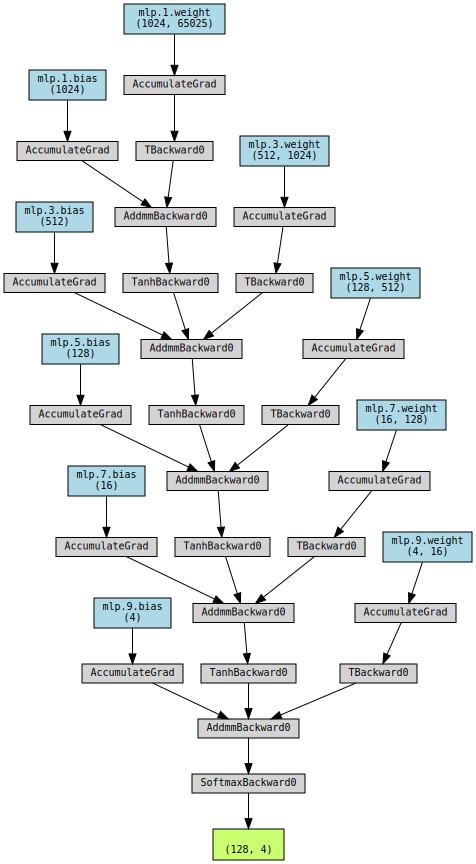

In [ ]:
from torchviz import make_dot

batch = next(iter(trainloader))
yhat = net(batch[0])
make_dot(yhat, params=dict(list(net.named_parameters())))

> Instantiate model, define hyper parameters, optimizer, loss function ant etc

In [ ]:
import torch.optim as optim

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
def train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer
) -> int:
    train_loss = 0
    total = 0
    correct = 0
    N = 0
    model.to(device)
    model.train()
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (inputs, labels) in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = correct / total
            N += labels.shape[0]
            pbar.set_description(f'Train   {epoch} | Loss:{train_loss/N:.2e} | Acc: {acc:.2f}')

    return train_loss

In [ ]:
def eval_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module = None,
) -> int:
    val_loss = 0
    total = 0
    correct = 0
    N = 0
    model.to(device)
    with torch.no_grad():
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (inputs, labels) in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss = loss.item()

                val_loss += epoch_loss
                predicted = outputs.argmax(dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = correct / total
                N += labels.shape[0]
                pbar.set_description(f'Val     {epoch} | Loss:{train_loss/N:.2e} | Acc: {acc:.2f}')
    return val_loss

In [ ]:
num_epochs = 20
least_loss = float('inf')
best_epoch_dict = None
train_loss_arr, val_loss_arr = list(), list()


for epoch in range(num_epochs):  # loop over the dataset multiple times

    train_loss = train_epoch(net, trainloader, criterion, optimizer)
    val_loss = eval_epoch(net, validloader, criterion)

    train_loss /= len(trainloader)
    val_loss /= len(validloader)

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    if train_loss < least_loss:
        least_loss = train_loss
        best_epoch_dict = net.state_dict().copy()
    
    print(f'\n[Epoch {epoch}]\t'
        f'Train Loss: {train_loss:.4f}\t'
        f'Validation Loss: {val_loss:.4f}\t'
    )

print('Finished Training')

Train   0 | Loss:1.10e-02 | Acc: 0.35: 100%|██████████| 25/25 [01:10<00:00,  2.84s/it]
Val     0 | Loss:7.70e-02 | Acc: 0.14: 100%|██████████| 4/4 [00:24<00:00,  6.14s/it]


[Epoch 0]	Train Loss: 1.3709	Validation Loss: 1.4181	



Train   1 | Loss:1.04e-02 | Acc: 0.50: 100%|██████████| 25/25 [01:02<00:00,  2.51s/it]
Val     1 | Loss:7.31e-02 | Acc: 0.26: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


[Epoch 1]	Train Loss: 1.3016	Validation Loss: 1.3704	



Train   2 | Loss:1.00e-02 | Acc: 0.58: 100%|██████████| 25/25 [00:47<00:00,  1.90s/it]
Val     2 | Loss:7.03e-02 | Acc: 0.55: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


[Epoch 2]	Train Loss: 1.2515	Validation Loss: 1.3160	



Train   3 | Loss:9.61e-03 | Acc: 0.69: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]
Val     3 | Loss:6.74e-02 | Acc: 0.61: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


[Epoch 3]	Train Loss: 1.1992	Validation Loss: 1.2720	



Train   4 | Loss:9.39e-03 | Acc: 0.72: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
Val     4 | Loss:6.58e-02 | Acc: 0.65: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


[Epoch 4]	Train Loss: 1.1719	Validation Loss: 1.2264	



Train   5 | Loss:9.28e-03 | Acc: 0.73: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
Val     5 | Loss:6.51e-02 | Acc: 0.58: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


[Epoch 5]	Train Loss: 1.1585	Validation Loss: 1.2601	



Train   6 | Loss:9.09e-03 | Acc: 0.75: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
Val     6 | Loss:6.37e-02 | Acc: 0.74: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


[Epoch 6]	Train Loss: 1.1345	Validation Loss: 1.1778	



Train   7 | Loss:8.82e-03 | Acc: 0.81: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]
Val     7 | Loss:6.18e-02 | Acc: 0.64: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


[Epoch 7]	Train Loss: 1.1008	Validation Loss: 1.2173	



Train   8 | Loss:8.62e-03 | Acc: 0.84: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]
Val     8 | Loss:6.04e-02 | Acc: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


[Epoch 8]	Train Loss: 1.0753	Validation Loss: 1.1500	



Train   9 | Loss:8.45e-03 | Acc: 0.86: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]
Val     9 | Loss:5.92e-02 | Acc: 0.76: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


[Epoch 9]	Train Loss: 1.0544	Validation Loss: 1.1209	



Train   10 | Loss:8.38e-03 | Acc: 0.86: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
Val     10 | Loss:5.88e-02 | Acc: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


[Epoch 10]	Train Loss: 1.0462	Validation Loss: 1.1213	



Train   11 | Loss:8.24e-03 | Acc: 0.87: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
Val     11 | Loss:5.78e-02 | Acc: 0.76: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


[Epoch 11]	Train Loss: 1.0283	Validation Loss: 1.1072	



Train   12 | Loss:8.26e-03 | Acc: 0.85: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]
Val     12 | Loss:5.79e-02 | Acc: 0.74: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


[Epoch 12]	Train Loss: 1.0308	Validation Loss: 1.1042	



Train   13 | Loss:7.95e-03 | Acc: 0.90: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]
Val     13 | Loss:5.57e-02 | Acc: 0.73: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


[Epoch 13]	Train Loss: 0.9922	Validation Loss: 1.1221	



Train   14 | Loss:7.77e-03 | Acc: 0.92: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
Val     14 | Loss:5.45e-02 | Acc: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


[Epoch 14]	Train Loss: 0.9703	Validation Loss: 1.0947	



Train   15 | Loss:7.69e-03 | Acc: 0.93: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]
Val     15 | Loss:5.39e-02 | Acc: 0.76: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


[Epoch 15]	Train Loss: 0.9595	Validation Loss: 1.0766	



Train   16 | Loss:7.68e-03 | Acc: 0.92: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
Val     16 | Loss:5.39e-02 | Acc: 0.69: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


[Epoch 16]	Train Loss: 0.9587	Validation Loss: 1.1266	



Train   17 | Loss:8.08e-03 | Acc: 0.85: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
Val     17 | Loss:5.66e-02 | Acc: 0.69: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


[Epoch 17]	Train Loss: 1.0078	Validation Loss: 1.1402	



Train   18 | Loss:7.61e-03 | Acc: 0.92: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
Val     18 | Loss:5.34e-02 | Acc: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


[Epoch 18]	Train Loss: 0.9498	Validation Loss: 1.0697	



Train   19 | Loss:7.66e-03 | Acc: 0.91: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
Val     19 | Loss:5.37e-02 | Acc: 0.76: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


[Epoch 19]	Train Loss: 0.9563	Validation Loss: 1.0625	
Finished Training


> Plot metrics graph for different epochs

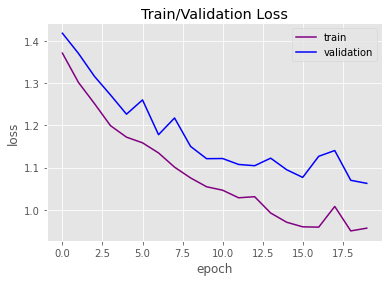

In [ ]:
def plot_loss(train_loss, val_loss, epochs):
    plt.plot(epochs, train_loss, color='purple', label='train')
    plt.plot(epochs, val_loss, color='blue', label='validation')
    plt.title(f'Train/Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

plot_loss(train_loss_arr, val_loss_arr, list(range(num_epochs)))

# Test Model (20)

> Test your model on test-set and plot confusion matrix

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for _, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

Accuracy of the network on the test images: 74.92 %


In [ ]:
classes = df['class_name'].unique()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_true = list()
y_pred = list()

# again no gradients needed
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_true.append([int(label)])
            y_pred.append([int(prediction)])


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Spirals is 33.9 %
Accuracy for class: Lenticulars is 57.1 %
Accuracy for class: Ellipticals is 87.0 %
Accuracy for class: Irregulars is 28.6 %


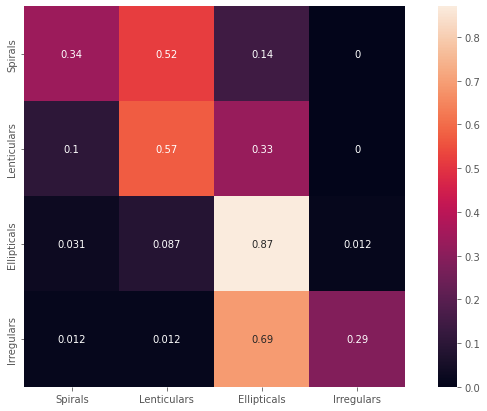

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True, square=True)
plt.savefig('conf_matrix.png')

In [ ]:
f1 = f1_score(y_true, y_pred, average='macro')

print('F1 score on test set: %.4f' % f1)

F1 score on test set: 0.5247
